Cats vs Dogs!

In [ ]:
# get & pre process data

!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

--2020-11-11 00:09:40--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.176, 172.217.15.112, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   191MB/s    in 0.3s    

2020-11-11 00:09:40 (191 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

['cat.937.jpg', 'cat.395.jpg', 'cat.963.jpg', 'cat.497.jpg', 'cat.88.jpg', 'cat.557.jpg', 'cat.247.jpg', 'cat.124.jpg', 'cat.459.jpg', 'cat.926.jpg']
['dog.73.jpg', 'dog.940.jpg', 'dog.647.jpg', 'dog.537.jpg', 'dog.188.jpg', 'dog.160.jpg', 'dog.786.jpg', 'dog.213.jpg', 'dog.937.jpg', 'dog.305.jpg']
total training cat images : 1000
total training dog images : 1000
total validatio

### Look at photos

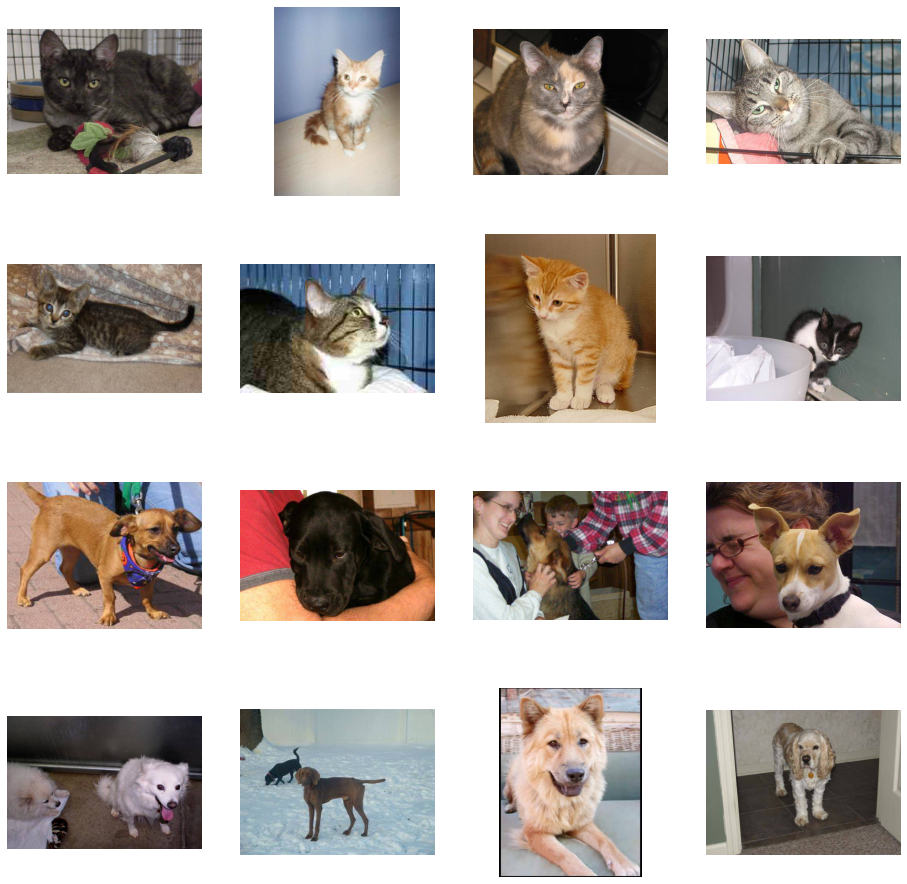

In [ ]:

%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4
pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

### Build Model

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)            

### ImageDataGenerator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     

validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=15,
                              validation_steps=50,
                              verbose=2)

Epoch 1/15
100/100 - 8s - loss: 0.7602 - accuracy: 0.5645 - val_loss: 0.6711 - val_accuracy: 0.5720
Epoch 2/15
100/100 - 8s - loss: 0.6168 - accuracy: 0.6695 - val_loss: 0.5951 - val_accuracy: 0.6810
Epoch 3/15
100/100 - 8s - loss: 0.5327 - accuracy: 0.7380 - val_loss: 0.5626 - val_accuracy: 0.7250
Epoch 4/15
100/100 - 8s - loss: 0.4481 - accuracy: 0.7940 - val_loss: 0.6370 - val_accuracy: 0.6970
Epoch 5/15
100/100 - 8s - loss: 0.3536 - accuracy: 0.8445 - val_loss: 0.7145 - val_accuracy: 0.6900
Epoch 6/15
100/100 - 8s - loss: 0.2520 - accuracy: 0.8935 - val_loss: 0.6100 - val_accuracy: 0.7330
Epoch 7/15
100/100 - 8s - loss: 0.1698 - accuracy: 0.9335 - val_loss: 0.8985 - val_accuracy: 0.7060
Epoch 8/15
100/100 - 8s - loss: 0.1155 - accuracy: 0.9545 - val_loss: 1.0574 - val_accuracy: 0.7340
Epoch 9/15
100/100 - 8s - loss: 0.0779 - accuracy: 0.9795 - val_loss: 1.1957 - val_accuracy: 0.7300
Epoch 10/15
100/100 - 8s - loss: 0.0726 - accuracy: 0.9765 - val_loss: 1.2532 - val_accuracy: 0.7110

### Plot Accuracy & Loss

Text(0.5, 1.0, 'Training and validation loss')

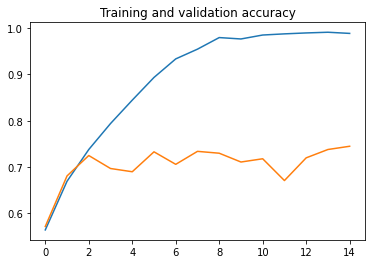

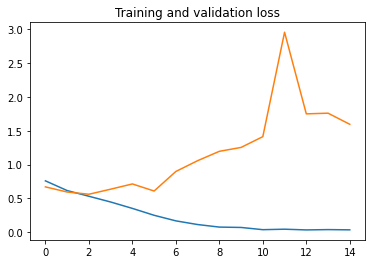

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) # Get number of epochs


plt.plot( epochs,acc )
plt.plot(epochs,val_acc )
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs,loss)
plt.plot(epochs,val_loss)
plt.title('Training and validation loss')